In [1]:
import git
import os

repo = git.Repo('.', search_parent_directories=True)
os.chdir(str(repo.working_tree_dir) + '/src')

In [83]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from demos import prepare_data, plot_data, plot_revenue_per_weekday, plot_avg_revenue_per_weekday, create_test_and_train_set

%matplotlib inline
%load_ext autoreload
%autoreload 2

np.set_printoptions(precision=2)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [88]:
wheater_path = repo.working_tree_dir + '/data/wheater_data.csv' 
revenue_path = repo.working_tree_dir + '/data/revenue_data.csv' 
df = prepare_data(wheater_path, revenue_path)
train_df, test_df = create_test_and_train_set(df)

/Users/jonasfischer/Library/CloudStorage/OneDrive-Persönlich/Projekte/Restaurant-Revenue-Forecasting/src/demos.py:170: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df.yesterday_revenue.iloc[0] = df.revenue.iloc[0]
/Users/jonasfischer/Libra

In [91]:
df.sort_values('bridge_day', ascending=False).head()

,tavg,tmin,tmax,prcp,wdir,wspd,pres,national_holiday,holiday,revenue,...,holiday_all_germany,national_and_holiday,DOW,yesterday_revenue,three_day_revenue,week_revenue,bridge_day,day,month,year
date,,,,,,,,,,,,,,,,,,,,,
2024-05-31,13.6,11.8,16.3,2.0,297,11.6,1009.9,0,1,3485,...,0,0,4,3185.0,2200.333333,2984.571429,1,31,5,2024
2024-05-10,15.9,9.2,21.8,0.0,64,9.7,1022.4,0,0,4313,...,0,0,4,4362.0,2610.000000,3049.857143,1,10,5,2024
2023-12-25,9.1,8.5,9.7,7.2,242,26.2,1014.3,1,1,2252,...,1,1,0,2252.0,2830.000000,2724.285714,1,25,12,2023
2023-10-02,18.1,12.7,25.3,0.0,120,7.6,1022.0,0,0,4848,...,0,0,0,5185.0,4018.000000,2742.142857,1,2,10,2023
2023-06-09,22.3,15.8,28.0,0.0,87,14.9,1012.7,0,1,3315,...,0,0,4,4039.0,2586.666667,3026.428571,1,9,6,2023


/Users/jonasfischer/Library/CloudStorage/OneDrive-Persönlich/Projekte/Restaurant-Revenue-Forecasting/src/demos.py:199: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.


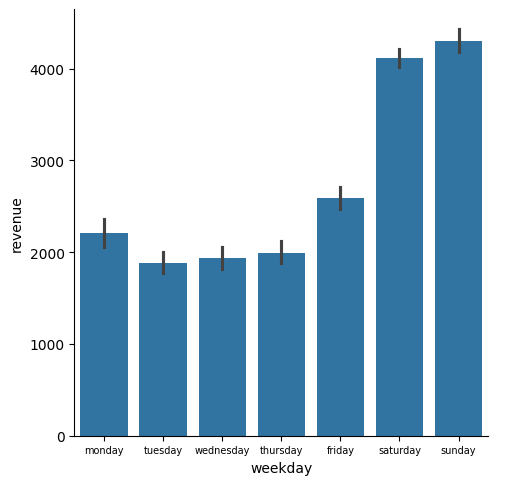

In [60]:
plot_avg_revenue_per_weekday(df)

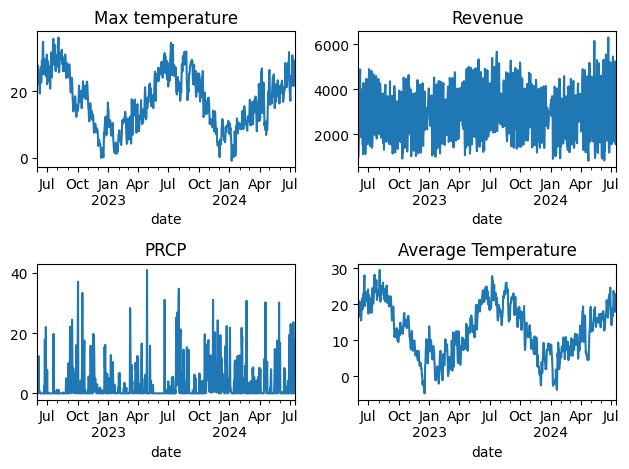

In [5]:
plot_data(df)

/Users/jonasfischer/Library/CloudStorage/OneDrive-Persönlich/Projekte/Restaurant-Revenue-Forecasting/src/demos.py:219: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.ax.set_xticklabels(g.ax.get_xticklabels(), fontsize=7)


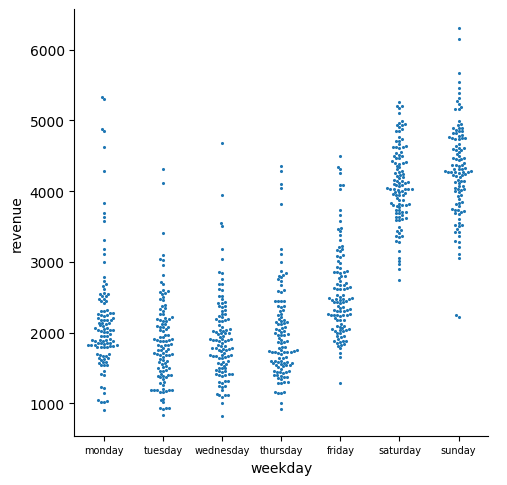

In [68]:
plot_revenue_per_weekday(df)

In [99]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
import scipy.stats as stats

X_train = train_df.drop('revenue', axis=1)
X_test = test_df.drop('revenue', axis=1)

Y_train = train_df['revenue']
Y_test = test_df['revenue']

KeyboardInterrupt: 